In [3]:
import numpy as np
import matplotlib.pyplot as plt

##### Below is a generalised model of simple_model.ipynb, allowing for any number of segments.
This model has a few assumptions:
* 1D model, each segment can only transfer heat to neighbouring segments
* There is a heat source which supplies (or draws) heat from segment 0, the magnitude of which is set by Q_in
* The final segment may disspiate heat to surroundings. The outside temperature is set by T_out.

In [16]:
class system():
    def __init__(self, k, c, T, T_out, Q_in):
        """
        Initialise class and set system parameters

        Parameters
        ----------
        k : array of floats
            Thermal conductivity of segments
        c : array of floats
            Heat capacity of segments
        T : array of floats
            Initial temperature of segments
        T_out : float
            Outside temperature (Celcius)
        Q_in : float
             Heat supply to segment 0 (Watts)
        """
        self.k = np.array(k) # Thermal conductivity of segments
        self.c = np.array(c) # Heat capacity of segments
        self.T = np.array(T) # Temperatures of segments
#         self.T_c = T_c # Temperature of central node
        
        n_br, n_seg = self.T.shape
        self.n_br  = n_br # Number of branches
        self.n_seg = n_seg # Number of segments per branch 
        # NOTE currently all branches must have same no. of segments, need to change this (or have empty segments to ensure same shape)
        
        assert (len(self.k) == n_br) & (len(self.c) == n_br), 'input parameter shape mismatch'
        
        self.T_out = np.array(T_out)
        self.Q_in = Q_in
        
    def update(self, timestep):
        """
        Calculate heat flux between segments and update temperatures

        Parameters
        ----------
        timestep : float
            Time interval between iterations
        Q_in : float
            Updated value of input heat 
        """
        heat_flux = np.diff(np.hstack((self.T,self.T_out[:,np.newaxis])))*self.c
        net_heat_flux = np.diff(heat_flux)
        
        # update non central nodes
        self.T[:, 1:] += ( net_heat_flux / self.k[:,1:] ) * timestep
        
        # update central node
        self.T[:, 0] += ( (heat_flux[:,0] / self.k[:,0]).sum() + self.Q_in ) * timestep 
        
    def run(self, iterations, timestep, plot=True):
        """
        Run simulation for given number of iterations with given timestep

        Parameters
        ----------
        iterations : int
            number of iterations to run the simulation
        
        timestep : float
            time interval between each iteration
        
        plot : bool, default = True
            Set to False to omit plot

        Returns
        -------
        Ts : ndarray, shape (number of iterations, number of segments)
            numpy array of temperatures for each segment, for each timestep
        """
        Ts = np.empty(shape=(iterations, self.n_br, self.n_seg))
        Qs = []
        for i in range(iterations):
            self.Q_in = 0.5 * ( 1 + 0.6*np.sin(2*np.pi*i/50.0)) # generalise this to any function or input data
            sys.update(timestep)
            Ts[i] = sys.T
            Qs.append(self.Q_in)
            
        Ts = np.transpose(Ts,axes=(1,2,0)) # New shape has (n_branches, n_segments, n_iterations)
        
        if plot:
            
            time = np.linspace(0,iterations*timestep/(3600*24),iterations, endpoint=False)
            fig, ax = plt.subplots(1,1, figsize=(20,10))
            for i, T_br in enumerate(Ts):
                for j, T_seg in enumerate(T_br[1:]):
                    ax.plot(time, T_seg, label='branch: {}, segment: {}'.format(i,j))
            ax.plot(time, Ts[0,0,:], label='Central temperature')
            ax.set(xlabel='Time (days)', ylabel='Temperature (C)')
            ax.legend()
            
        return Ts, Qs

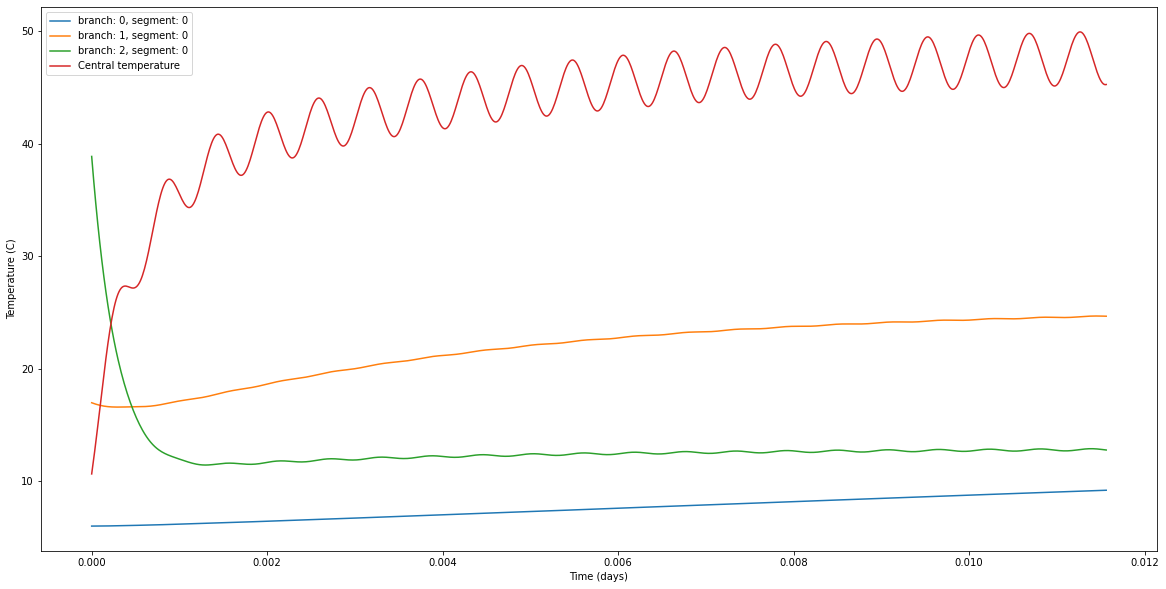

In [17]:
# More complex example, 7 segments in series
# k = [[6e5, 2.5e6], [1.5e7, 2.1e5], [6.5e6, 6.9e6]]
# c = [[800.0, 500.0], [300.0, 150.0], [400.0, 1000.0]]
k = [[1e6, 1e7], [1e5, 1e6], [1e8, 1e5]]
c = [[1000.0, 1500.0], [2000.0, 3000.0], [500.0, 3000.0]]
T = [[10.0, 6], [10.0, 17.0], [10.0, 40]] # first entry in each sub array must be the same, it is the temperature of the central node
T_out = [5.0, 10.0, 7.0]
heatinput = 0.5
# Initialise class with system parameters
sys = system(k, c, T, T_out, heatinput)

# Run simulation. This recreates simple_model.ipynb showing that our generalised model works.
Ts, Qs = sys.run(iterations=1000, timestep=1)